<a href="https://colab.research.google.com/github/YonDraco/learn-pyimagesearch/blob/master/4_keras_autoencoder_cbir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

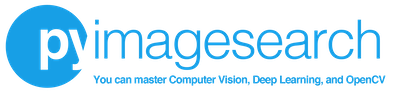

# Autoencoders for Content-based Image Retrieval with Keras and TensorFlow
### by [PyImageSearch.com](http://www.pyimagesearch.com)

## Welcome to **[PyImageSearch Plus](http://pyimg.co/plus)** Jupyter Notebooks!

This notebook is associated with the [Autoencoders for Content-based Image Retrieval with Keras and TensorFlow](https://www.pyimagesearch.com/2020/03/30/autoencoders-for-content-based-image-retrieval-with-keras-and-tensorflow/) blog post published on 2020-03-30.

Only the code for the blog post is here. Most codeblocks have a 1:1 relationship with what you find in the blog post with two exceptions: (1) Python classes are not separate files as they are typically organized with PyImageSearch projects, and (2) Command Line Argument parsing is replaced with an `args` dictionary that you can manipulate as needed.

We recommend that you execute (press ▶️) the code block-by-block, as-is, before adjusting parameters and `args` inputs. Once you've verified that the code is working, you are welcome to hack with it and learn from manipulating inputs, settings, and parameters. For more information on using Jupyter and Colab, please refer to these resources:

*   [Jupyter Notebook User Interface](https://jupyter-notebook.readthedocs.io/en/stable/notebook.html#notebook-user-interface)
*   [Overview of Google Colaboratory Features](https://colab.research.google.com/notebooks/basic_features_overview.ipynb)

As a reminder, these PyImageSearch Plus Jupyter Notebooks are not for sharing; please refer to the **Copyright** directly below and **Code License Agreement** in the last cell of this notebook. 

Happy hacking!

*Adrian*

<hr>

***Copyright:*** *The contents of this Jupyter Notebook, unless otherwise indicated, are Copyright 2020 Adrian Rosebrock, PyimageSearch.com. All rights reserved. Content like this is made possible by the time invested by the authors. If you received this Jupyter Notebook and did not purchase it, please consider making future content possible by joining PyImageSearch Plus at http://pyimg.co/plus/ today.*

### Install the necessary packages

In [1]:
!pip install tensorflow==2.2.0

     |████████████████████████████████| 516.2 MB 4.4 kB/s 
     |████████████████████████████████| 454 kB 56.0 MB/s 
     |████████████████████████████████| 2.9 MB 60.3 MB/s 
     |████████████████████████████████| 3.0 MB 57.4 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.6.0
    Uninstalli

### Download the code zip file

In [2]:
!wget https://s3-us-west-2.amazonaws.com/static.pyimagesearch.com/keras-autoencoder-cbir/keras-autoencoder-cbir.zip
!unzip -qq keras-autoencoder-cbir.zip
%cd keras-autoencoder-cbir

--2021-08-26 09:39:01--  https://s3-us-west-2.amazonaws.com/static.pyimagesearch.com/keras-autoencoder-cbir/keras-autoencoder-cbir.zip
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.209.184
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.209.184|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5719995 (5.5M) [application/zip]
Saving to: ‘keras-autoencoder-cbir.zip’

keras-autoencoder-c 100%[===================>]   5.45M  4.22MB/s    in 1.3s    

2021-08-26 09:39:03 (4.22 MB/s) - ‘keras-autoencoder-cbir.zip’ saved [5719995/5719995]

/content/keras-autoencoder-cbir


## Blog Post Code

### Import Packages

In [3]:
# import the necessary packages
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model
from imutils import build_montages
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import cv2

### Function to display images in Jupyter Notebooks and Google Colab

In [4]:
def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### Implementing our convolutional autoencoder architecture for image retrieval

In [5]:
class ConvAutoencoder:
	@staticmethod
	def build(width, height, depth, filters=(32, 64), latentDim=16):
		# initialize the input shape to be "channels last" along with
		# the channels dimension itself
		# channels dimension itself
		inputShape = (height, width, depth)
		chanDim = -1

		# define the input to the encoder
		inputs = Input(shape=inputShape)
		x = inputs

		# loop over the number of filters
		for f in filters:
			# apply a CONV => RELU => BN operation
			x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)

		# flatten the network and then construct our latent vector
		volumeSize = K.int_shape(x)
		x = Flatten()(x)
		latent = Dense(latentDim, name="encoded")(x)

		# start building the decoder model which will accept the
		# output of the encoder as its inputs
		x = Dense(np.prod(volumeSize[1:]))(latent)
		x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

		# loop over our number of filters again, but this time in
		# reverse order
		for f in filters[::-1]:
			# apply a CONV_TRANSPOSE => RELU => BN operation
			x = Conv2DTranspose(f, (3, 3), strides=2,
				padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)

		# apply a single CONV_TRANSPOSE layer used to recover the
		# original depth of the image
		x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
		outputs = Activation("sigmoid", name="decoded")(x)

		# construct our autoencoder model
		autoencoder = Model(inputs, outputs, name="autoencoder")

		# return the autoencoder model
		return autoencoder

### Creating the autoencoder training script using Keras and TensorFlow

In [6]:
def visualize_predictions(decoded, gt, samples=10):
	# initialize our list of output images
	outputs = None

	# loop over our number of output samples
	for i in range(0, samples):
		# grab the original image and reconstructed image
		original = (gt[i] * 255).astype("uint8")
		recon = (decoded[i] * 255).astype("uint8")

		# stack the original and reconstructed image side-by-side
		output = np.hstack([original, recon])

		# if the outputs array is empty, initialize it as the current
		# side-by-side image display
		if outputs is None:
			outputs = output

		# otherwise, vertically stack the outputs
		else:
			outputs = np.vstack([outputs, output])

	# return the output images
	return outputs

In [7]:
# construct the argument parse and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-m", "--model", type=str, required=True,
#	help="path to output trained autoencoder")
#ap.add_argument("-v", "--vis", type=str, default="recon_vis.png",
#	help="path to output reconstruction visualization file")
#ap.add_argument("-p", "--plot", type=str, default="plot.png",
#	help="path to output plot file")
#args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"model": "output/autoencoder.h5",
	"vis": "recon_vis.png",
	"plot": "plot.png"
}

In [8]:
# initialize the number of epochs to train for, initial learning rate,
# and batch size
EPOCHS = 20
INIT_LR = 1e-3
BS = 32

# load the MNIST dataset
print("[INFO] loading MNIST dataset...")
((trainX, _), (testX, _)) = mnist.load_data()

# add a channel dimension to every image in the dataset, then scale
# the pixel intensities to the range [0, 1]
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
autoencoder = ConvAutoencoder.build(28, 28, 1)
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
autoencoder.compile(loss="mse", optimizer=opt)

# train the convolutional autoencoder
H = autoencoder.fit(
	trainX, trainX,
	validation_data=(testX, testX),
	epochs=EPOCHS,
	batch_size=BS)

[INFO] loading MNIST dataset...
11493376/11490434 [==============================] - 0s 0us/step
[INFO] building autoencoder...
Epoch 1/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0187 - val_loss: 0.0105
Epoch 2/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0102 - val_loss: 0.0094
Epoch 3/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 4/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0085 - val_loss: 0.0083
Epoch 5/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0081 - val_loss: 0.0080
Epoch 6/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0078 - val_loss: 0.0077
Epoch 7/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0076 - val_loss: 0.0075
Epoch 8/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0074 - val_loss: 0.0074
Epoch 9/20
1875/1875 [==============================] - 

[INFO] making predictions...


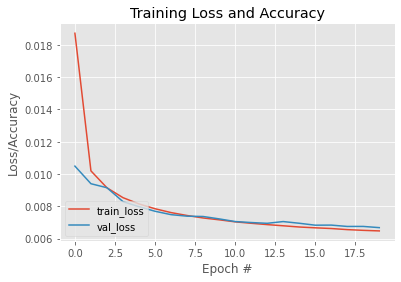

[INFO] saving autoencoder...


In [9]:
# use the convolutional autoencoder to make predictions on the
# testing images, construct the visualization, and then save it
# to disk
print("[INFO] making predictions...")
decoded = autoencoder.predict(testX)
vis = visualize_predictions(decoded, testX)
cv2.imwrite(args["vis"], vis)

# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"])
plt.show()

# serialize the autoencoder model to disk
print("[INFO] saving autoencoder...")
autoencoder.save(args["model"], save_format="h5")

### Implementing image indexer using the trained autoencoder

In [10]:
# construct the argument parse and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-m", "--model", type=str, required=True,
#	help="path to trained autoencoder")
#ap.add_argument("-i", "--index", type=str, required=True,
#	help="path to output features index file")
#args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"model": "output/autoencoder.h5",
	"index": "output/index.pickle"
}

In [11]:
# load the MNIST dataset
print("[INFO] loading MNIST training split...")
((trainX, _), (testX, _)) = mnist.load_data()

# add a channel dimension to every image in the training split, then
# scale the pixel intensities to the range [0, 1]
trainX = np.expand_dims(trainX, axis=-1)
trainX = trainX.astype("float32") / 255.0

[INFO] loading MNIST training split...


In [12]:
# load our autoencoder from disk
print("[INFO] loading autoencoder model...")
autoencoder = load_model(args["model"])

# create the encoder model which consists of *just* the encoder
# portion of the autoencoder
encoder = Model(inputs=autoencoder.input,
	outputs=autoencoder.get_layer("encoded").output)

# quantify the contents of our input images using the encoder
print("[INFO] encoding images...")
features = encoder.predict(trainX)

[INFO] loading autoencoder model...
[INFO] encoding images...


In [13]:
# construct a dictionary that maps the index of the MNIST training
# image to its corresponding latent-space representation
indexes = list(range(0, trainX.shape[0]))
data = {"indexes": indexes, "features": features}

# write the data dictionary to disk
print("[INFO] saving index...")
f = open(args["index"], "wb")
f.write(pickle.dumps(data))
f.close()

[INFO] saving index...


### Implementing the image search and retrieval script using Keras and TensorFlow

In [14]:
def euclidean(a, b):
	# compute and return the euclidean distance between two vectors
	return np.linalg.norm(a - b)

In [15]:
def perform_search(queryFeatures, index, maxResults=64):
	# initialize our list of results
	results = []

	# loop over our index
	for i in range(0, len(index["features"])):
		# compute the euclidean distance between our query features
		# and the features for the current image in our index, then
		# update our results list with a 2-tuple consisting of the
		# computed distance and the index of the image
		d = euclidean(queryFeatures, index["features"][i])
		results.append((d, i))

	# sort the results and grab the top ones
	results = sorted(results)[:maxResults]

	# return the list of results
	return results

In [16]:
# construct the argument parse and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-m", "--model", type=str, required=True,
#	help="path to trained autoencoder")
#ap.add_argument("-i", "--index", type=str, required=True,
#	help="path to features index file")
#ap.add_argument("-s", "--sample", type=int, default=10,
#	help="# of testing queries to perform")
#args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"model": "output/autoencoder.h5",
	"index": "output/index.pickle",
    "sample": 10
}

In [17]:
# load the MNIST dataset
print("[INFO] loading MNIST dataset...")
((trainX, _), (testX, _)) = mnist.load_data()

# add a channel dimension to every image in the dataset, then scale
# the pixel intensities to the range [0, 1]
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

[INFO] loading MNIST dataset...


In [18]:
# load the autoencoder model and index from disk
print("[INFO] loading autoencoder and index...")
autoencoder = load_model(args["model"])
index = pickle.loads(open(args["index"], "rb").read())

# create the encoder model which consists of *just* the encoder
# portion of the autoencoder
encoder = Model(inputs=autoencoder.input,
	outputs=autoencoder.get_layer("encoded").output)

# quantify the contents of our input testing images using the encoder
print("[INFO] encoding testing images...")
features = encoder.predict(testX)

[INFO] loading autoencoder and index...
[INFO] encoding testing images...


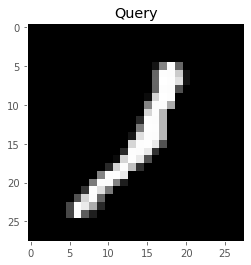

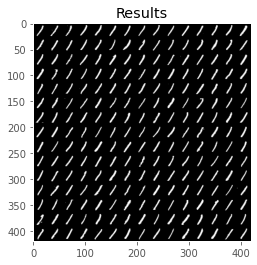

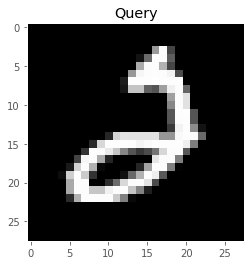

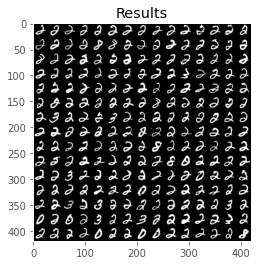

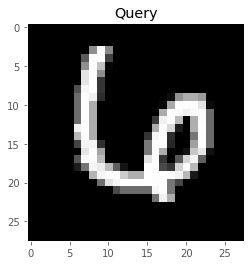

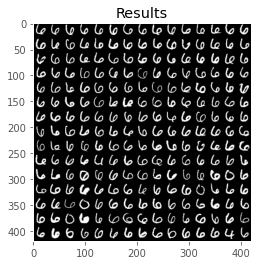

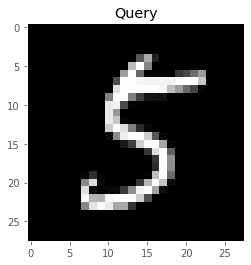

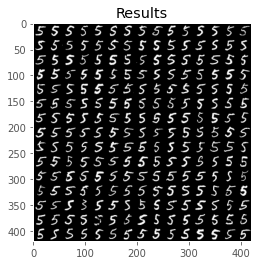

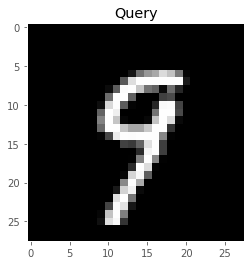

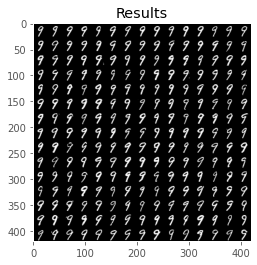

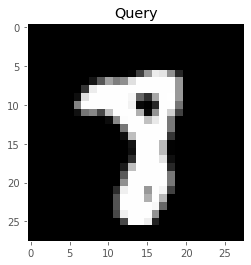

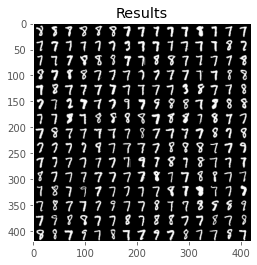

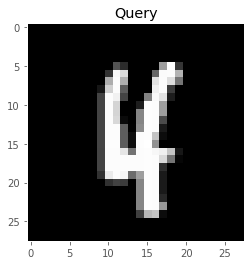

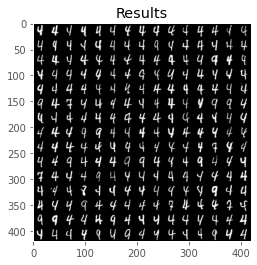

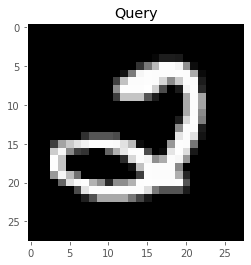

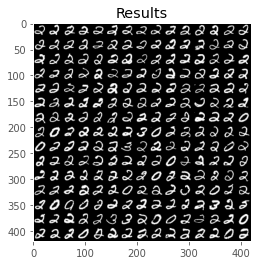

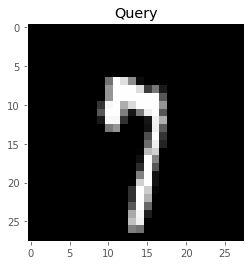

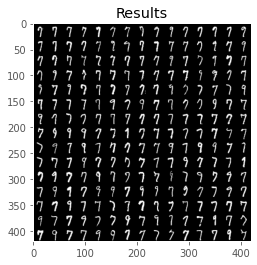

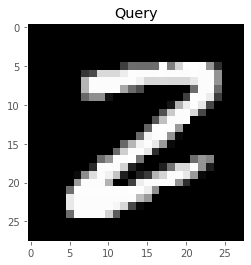

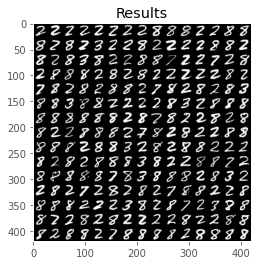

In [19]:
# randomly sample a set of testing query image indexes
queryIdxs = list(range(0, testX.shape[0]))
queryIdxs = np.random.choice(queryIdxs, size=args["sample"],
	replace=False)

# loop over the testing indexes
for i in queryIdxs:
	# take the features for the current image, find all similar
	# images in our dataset, and then initialize our list of result
	# images
	queryFeatures = features[i]
	results = perform_search(queryFeatures, index, maxResults=225)
	images = []

	# loop over the results
	for (d, j) in results:
		# grab the result image, convert it back to the range
		# [0, 255], and then update the images list
		image = (trainX[j] * 255).astype("uint8")
		image = np.dstack([image] * 3)
		images.append(image)

	# display the query image
	query = (testX[i] * 255).astype("uint8")
	plt_imshow("Query", query)

	# build a montage from the results and display it
	montage = build_montages(images, (28, 28), (15, 15))[0]
	plt_imshow("Results", montage)

For a detailed walkthrough of the concepts and code, be sure to refer to the full tutorial, [*Autoencoders for Content-based Image Retrieval with Keras and TensorFlow*](https://www.pyimagesearch.com/2020/03/30/autoencoders-for-content-based-image-retrieval-with-keras-and-tensorflow/) published on 2020-03-30.

# Code License Agreement
```
Copyright (c) 2020 PyImageSearch.com

SIMPLE VERSION
Feel free to use this code for your own projects, whether they are
purely educational, for fun, or for profit. THE EXCEPTION BEING if
you are developing a course, book, or other educational product.
Under *NO CIRCUMSTANCE* may you use this code for your own paid
educational or self-promotional ventures without written consent
from Adrian Rosebrock and PyImageSearch.com.

LONGER, FORMAL VERSION
Permission is hereby granted, free of charge, to any person obtaining
a copy of this software and associated documentation files
(the "Software"), to deal in the Software without restriction,
including without limitation the rights to use, copy, modify, merge,
publish, distribute, sublicense, and/or sell copies of the Software,
and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:
The above copyright notice and this permission notice shall be
included in all copies or substantial portions of the Software.
Notwithstanding the foregoing, you may not use, copy, modify, merge,
publish, distribute, sublicense, create a derivative work, and/or
sell copies of the Software in any work that is designed, intended,
or marketed for pedagogical or instructional purposes related to
programming, coding, application development, or information
technology. Permission for such use, copying, modification, and
merger, publication, distribution, sub-licensing, creation of
derivative works, or sale is expressly withheld.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES
OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS
BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN
ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
```